In [6]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
# Load the datasets
iata_icao = pd.read_csv("iata-icao.csv")
complaints_airport = pd.read_csv("complaints-by-airport.csv")
complaints_category = pd.read_csv("complaints-by-category.csv")
complaints_subcategory = pd.read_csv("complaints-by-subcategory.csv")

In [8]:
# Show the first few rows of each dataset to explore their contents
iata_icao.head(), complaints_airport.head(), complaints_category.head(), complaints_subcategory.head()

(  country_code region_name iata  icao                          airport  \
 0           AE    Abu Zaby  AAN  OMAL     Al Ain International Airport   
 1           AE    Abu Zaby  AUH  OMAA  Abu Dhabi International Airport   
 2           AE    Abu Zaby  AYM   NaN         Yas Island Seaplane Base   
 3           AE    Abu Zaby  AZI  OMAD      Al Bateen Executive Airport   
 4           AE    Abu Zaby  DHF  OMAM               Al Dhafra Air Base   
 
    latitude  longitude  
 0   24.2617    55.6092  
 1   24.4330    54.6511  
 2   24.4670    54.6103  
 3   24.4283    54.4581  
 4   24.2482    54.5477  ,
   pdf_report_date airport year_month  count
 0         2019-02     ABE    2015-01      0
 1         2019-02     ABE    2015-02      0
 2         2019-02     ABE    2015-03      0
 3         2019-02     ABE    2015-04      0
 4         2019-02     ABE    2015-05      2,
   pdf_report_date airport                           category year_month  \
 0         2019-02     ABE         Hazardous

Summarize Common Complaint Trends - 

In [10]:
# Merge airport complaint data with airport names using IATA code
# Filter US-based airports only (assumption: US airports will be in the complaints data)
us_airports = complaints_airport['airport'].unique()
iata_us = iata_icao[iata_icao['iata'].isin(us_airports)][['iata', 'airport']].rename(columns={'iata': 'airport', 'airport': 'airport_name'})

In [11]:
# Merge with complaints data
airport_summary = complaints_airport.merge(iata_us, on='airport', how='left')

In [12]:
# Total complaints per airport
total_by_airport = (
    airport_summary.groupby(['airport', 'airport_name'])['count']
    .sum()
    .reset_index()
    .sort_values(by='count', ascending=False)
)

In [13]:
# Total complaints by category
total_by_category = (
    complaints_category.groupby('clean_cat')['count']
    .sum()
    .reset_index()
    .sort_values(by='count', ascending=False)
)

In [14]:
# Monthly trends (all airports)
monthly_trends = (
    complaints_airport.groupby('year_month')['count']
    .sum()
    .reset_index()
)

In [15]:
# Show the top 10 complaint-heavy airports and categories, and monthly trend head
print("Top Airports by Complaints")
display(total_by_airport.head(10))

print("Top Complaint Categories")
display(total_by_category.head(10))

print("Complaint Volume Over Time")
display(monthly_trends.head(12))

Top Airports by Complaints


,airport,airport_name,count
231,LAX,Los Angeles International Airport,24794
219,JFK,John F. Kennedy International Airport,24677
137,EWR,Newark Liberty International Airport,24405
26,ATL,Hartsfield-Jackson Atlanta International Airport,23591
260,MCO,Orlando International Airport,22308
111,DEN,Denver International Airport,19015
305,ORD,Chicago O'Hare International Airport,18256
112,DFW,Dallas/Fort Worth International Airport,15954
229,LAS,Harry Reid International Airport,15937
272,MIA,Miami International Airport,14907


Top Complaint Categories


,clean_cat,count
14,Expedited Passenger Screening Program,569943
27,Mishandling of Passenger Property,128271
11,Customer Service,82168
40,Screening,64939
35,Property - Special Handling,46610
25,Locks,21889
33,Persons w/ Disabilities (PWD),17216
32,Patdown,16554
8,Civil Rights,14077
2,Airline,11537


Complaint Volume Over Time


,year_month,count
0,2015-01,7610
1,2015-02,5916
2,2015-03,6988
3,2015-04,6891
4,2015-05,6730
5,2015-06,7956
6,2015-07,7800
7,2015-08,9041
8,2015-09,8505
9,2015-10,8884


Create Visuals -

In [17]:
# Convert 'year_month' to datetime for trend analysis
monthly_trends['year_month'] = pd.to_datetime(monthly_trends['year_month'])

In [18]:
# Group to get monthly complaint counts per airport
airport_monthly = complaints_airport.groupby(['airport', 'year_month'])['count'].sum().reset_index()

Visual 1 Heat Map - 

In [20]:
# Create Heat Map
## Prepare complaint-by-category heatmap data
category_month = (
    complaints_category.groupby(['clean_cat', 'year_month'])['count']
    .sum()
    .reset_index()
)
category_month['year_month'] = pd.to_datetime(category_month['year_month'])
heatmap_data = category_month.pivot(index='clean_cat', columns='year_month', values='count').fillna(0)

In [21]:
# Set styles
sns.set(style="whitegrid")

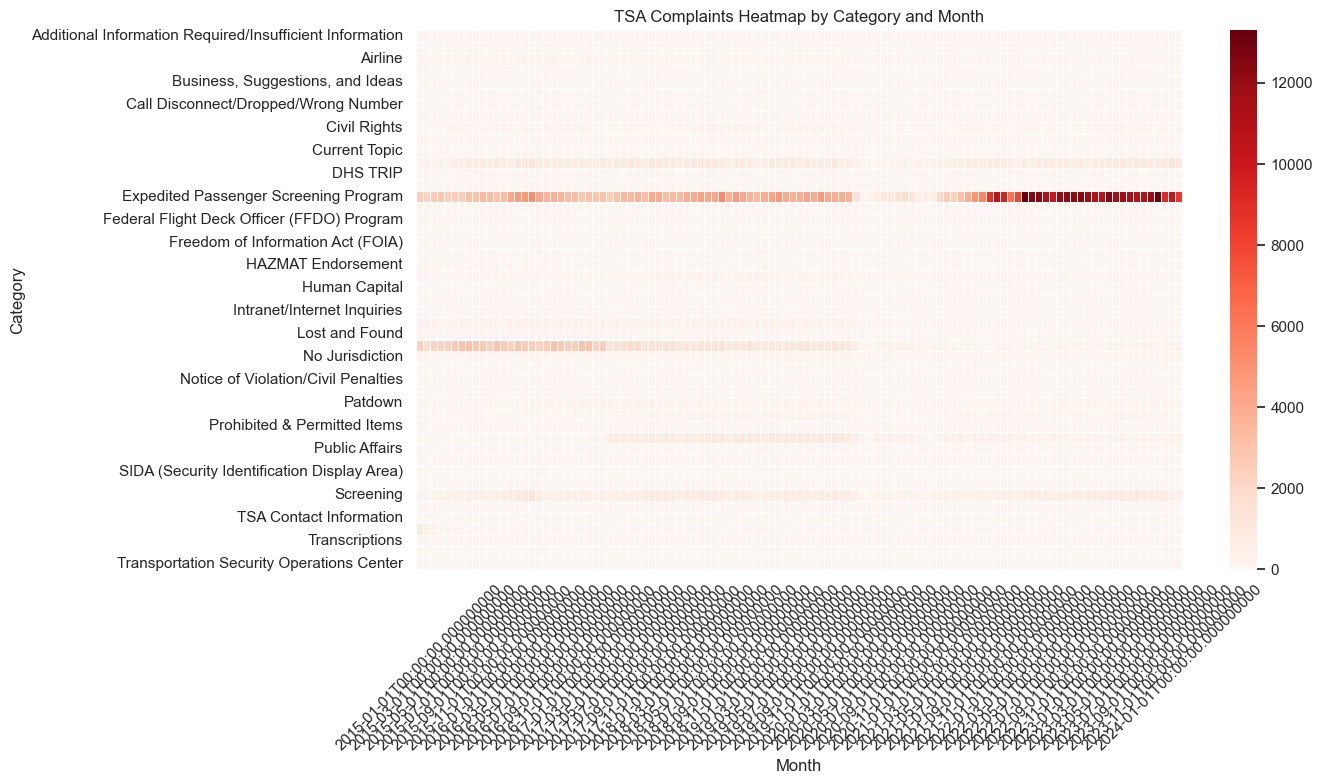

In [22]:
# 1. Heatmap - Category vs. Month
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=.5)
plt.title("TSA Complaints Heatmap by Category and Month")
plt.xlabel("Month")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visual 2 Box Plot - 

In [24]:
# Prepare box plot data (distribution of complaint counts by airport)
airport_monthly = complaints_airport.groupby(['airport', 'year_month'])['count'].sum().reset_index()

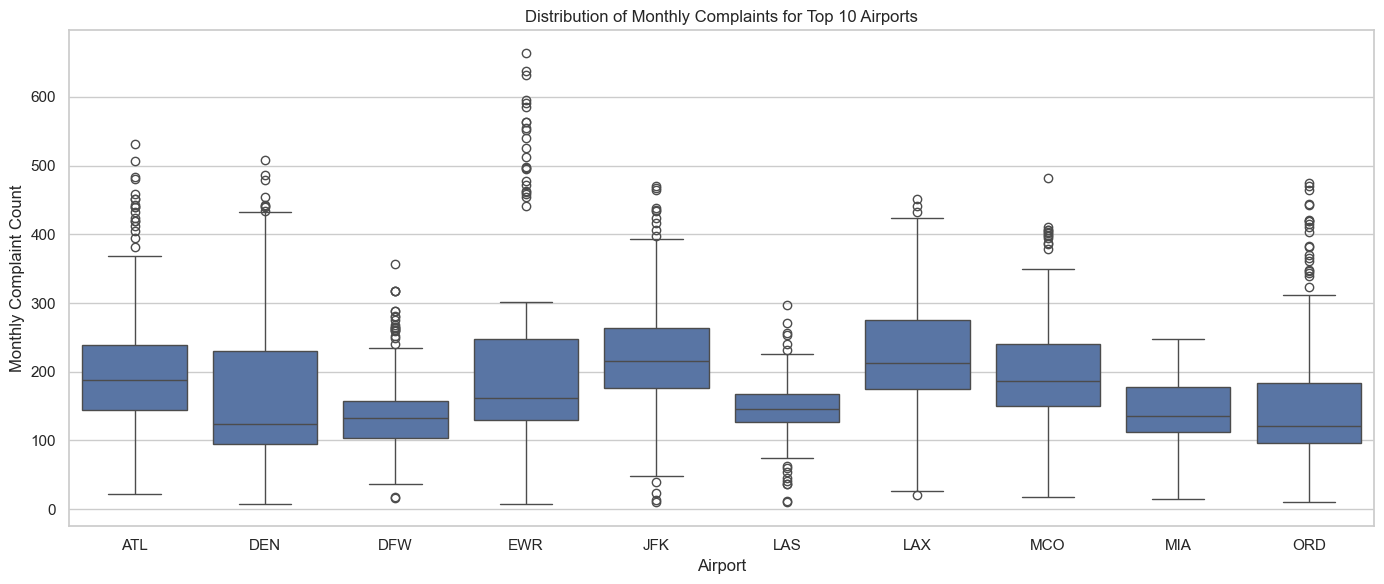

In [25]:
# 2. Box Plot - Distribution of Complaints by Airport
plt.figure(figsize=(14, 6))
top_airports = total_by_airport.head(10)['airport'].tolist()
sns.boxplot(data=airport_monthly[airport_monthly['airport'].isin(top_airports)], x='airport', y='count')
plt.title("Distribution of Monthly Complaints for Top 10 Airports")
plt.xlabel("Airport")
plt.ylabel("Monthly Complaint Count")
plt.tight_layout()
plt.show()

Visual 3 Line Chart -

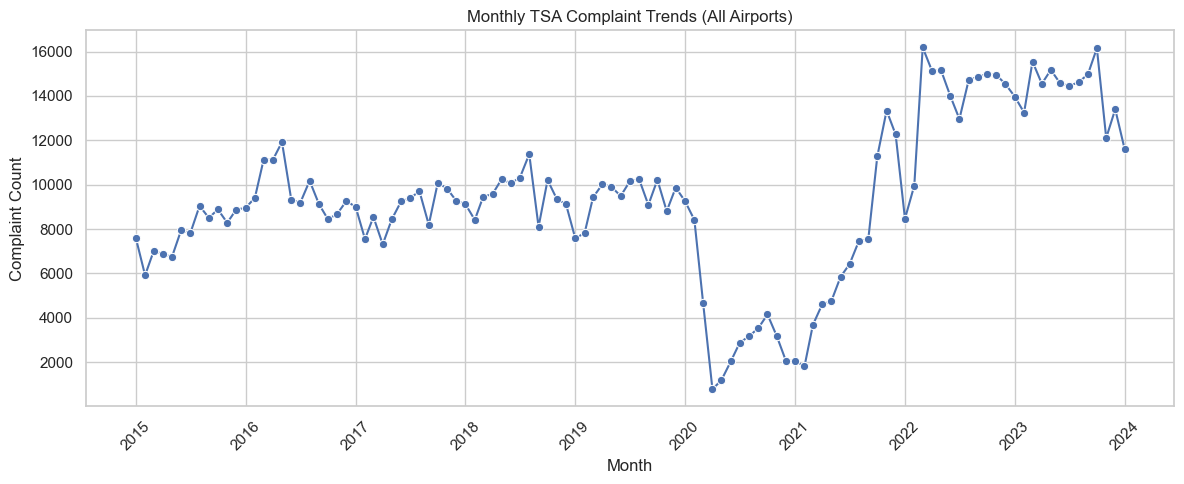

In [27]:
# 3. Line Chart - Complaints Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends, x='year_month', y='count', marker='o')
plt.title("Monthly TSA Complaint Trends (All Airports)")
plt.xlabel("Month")
plt.ylabel("Complaint Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visual 4 - Bar Chart of Airports with Highest Number of Complaints

In [29]:
# Prepare data for bar charts
top_airports_chart = total_by_airport.head(10).copy()
top_categories_chart = total_by_category.head(10).copy()

/var/folders/s2/g5_6pgyj3470mrz0wq1lz_780000gn/T/ipykernel_10344/645204037.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_airports_chart, y='airport_name', x='count', palette='Blues_d')


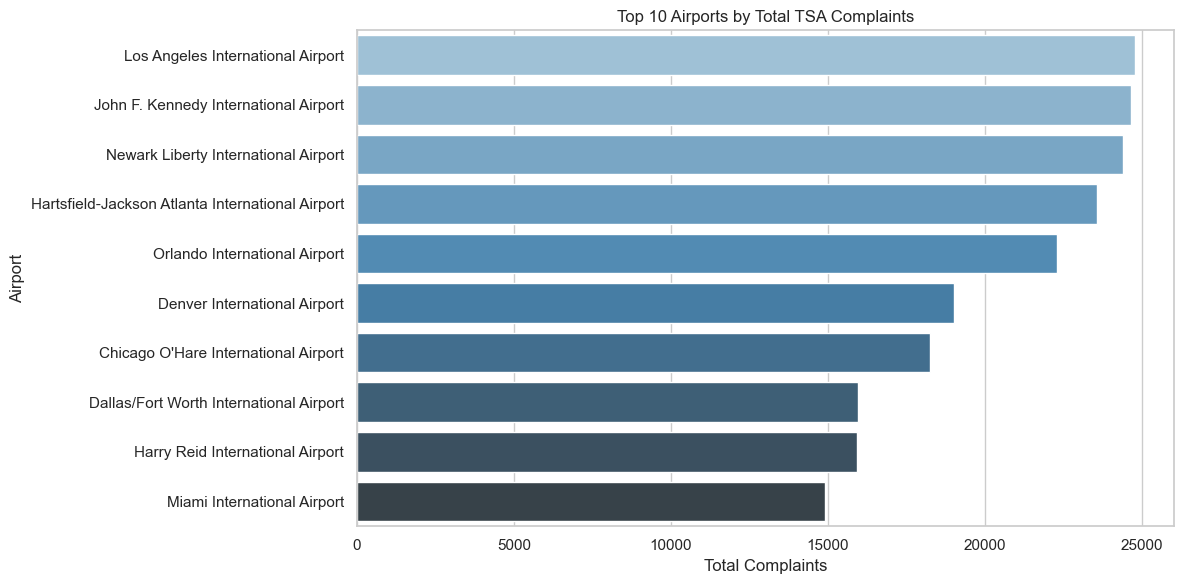

In [30]:
# 4. Bar Chart - Top 10 Airports by Total Complaints
plt.figure(figsize=(12, 6))
sns.barplot(data=top_airports_chart, y='airport_name', x='count', palette='Blues_d')
plt.title("Top 10 Airports by Total TSA Complaints")
plt.xlabel("Total Complaints")
plt.ylabel("Airport")
plt.tight_layout()
plt.show()

Visual 5 Bar Chart - Top Complaint Categories

/var/folders/s2/g5_6pgyj3470mrz0wq1lz_780000gn/T/ipykernel_10344/2596286960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories_chart, y='clean_cat', x='count', palette='Greens_d')


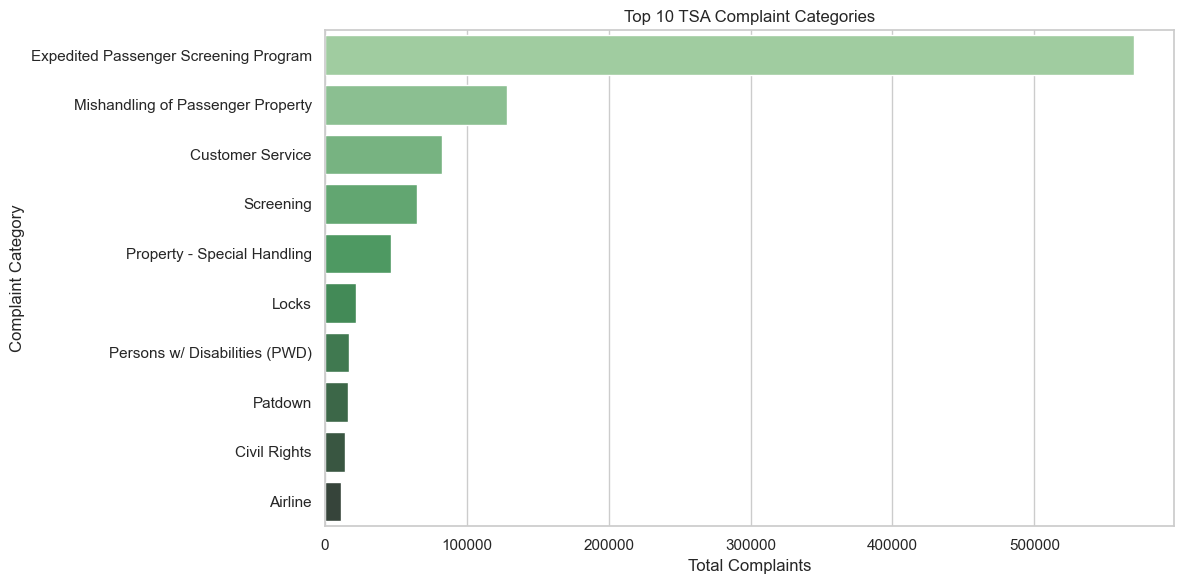

In [51]:
# 5. Bar Chart - Top 10 Complaint Categories
plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories_chart, y='clean_cat', x='count', palette='Greens_d')
plt.title("Top 10 TSA Complaint Categories")
plt.xlabel("Total Complaints")
plt.ylabel("Complaint Category")
plt.tight_layout()
plt.show()

Visual 6 Choropleth -

In [56]:
# Create spatial_data by merging airport totals with lat/lon info
spatial_data = total_by_airport.merge(
    iata_icao[['iata', 'latitude', 'longitude']],
    left_on='airport',
    right_on='iata',
    how='left'
).dropna(subset=['latitude', 'longitude'])

In [58]:
# Clean airport coordinates
spatial_data_clean = spatial_data.dropna(subset=['latitude', 'longitude'])

/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


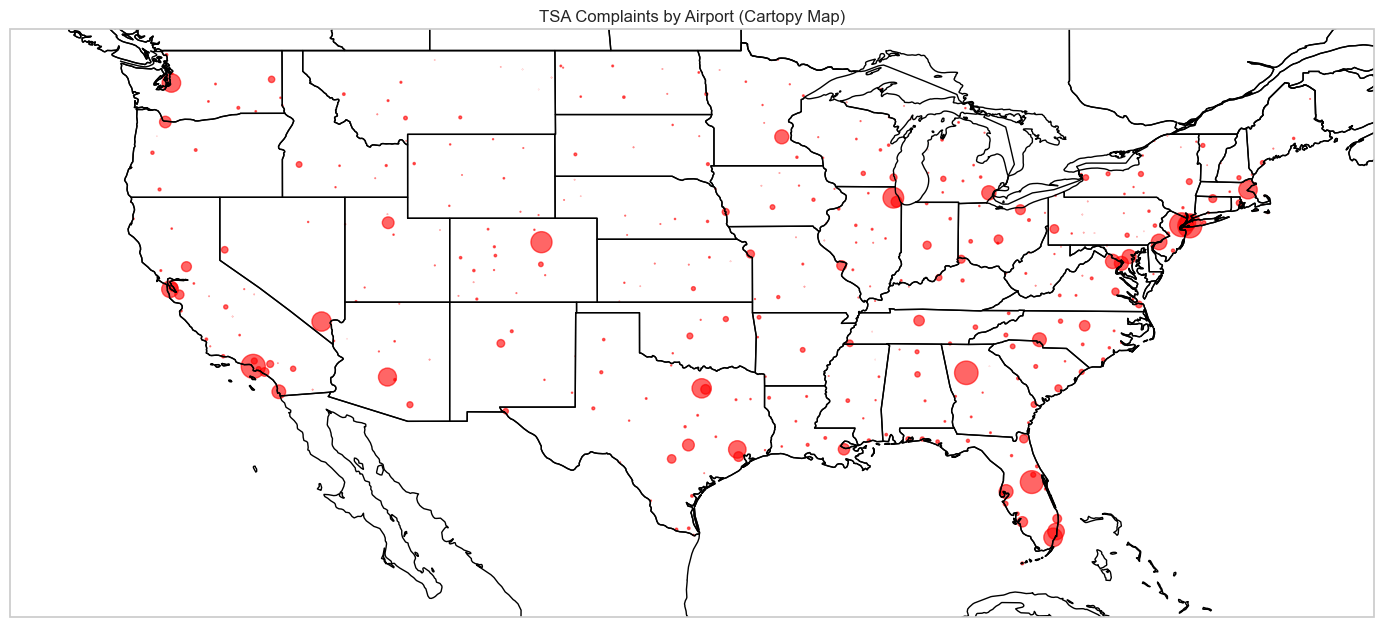

In [68]:
# Create the map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -65, 22, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.coastlines()

# Plot points
ax.scatter(
    spatial_data_clean['longitude'],
    spatial_data_clean['latitude'],
    s=spatial_data_clean['count'] / spatial_data_clean['count'].max() * 300,
    color='red',
    alpha=0.6,
    transform=ccrs.PlateCarree()
)

plt.title("TSA Complaints by Airport (Cartopy Map)")
plt.tight_layout()
plt.show()